In [1]:
import numpy as np
from utils import *
import pandas as pd
from sklearn.metrics import confusion_matrix

data = pd.read_table("data/rte_crowd.txt", header=None)
truth = pd.read_table("data/rte_truth.txt", header=None)


In [2]:
truth.nunique()

0    800
1      2
dtype: int64

In [3]:
data.nunique()

0    800
1    164
2      2
dtype: int64

In [4]:
import matplotlib.pyplot as plt


In [5]:
truth = truth.drop_duplicates()

In [6]:
data[~data[1].isin(data.merge(truth, on=0)["1_x"])].nunique()


0    0
1    0
2    0
dtype: int64

In [7]:
data[~data[1].isin(data.merge(truth, on=0)["1_x"])]

,0,1,2


In [8]:
truth.groupby(1).count()

,0
1,
1,400
2,400


In [9]:
n, m, k = np.max(np.array(data), axis=0)
print(n, m, k)


800 164 2


In [10]:
labels = transform_data(data)
labels

array([[ 1,  0,  1, ..., -1, -1, -1],
       [ 1,  0,  0, ...,  1,  0,  1],
       [ 1,  0,  1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int64)

In [11]:
ranking = truth.sort_values(1)[0]-1

In [12]:
merged = data.merge(truth,on=0)


In [13]:
# proportion of missing values
missing = np.mean(labels == -1)
print(missing)

0.9390243902439024


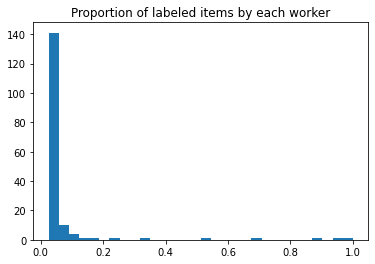

In [14]:
plt.hist(np.mean(labels != -1, axis=1), bins=30)
plt.title("Proportion of labeled items by each worker")
plt.savefig("pic/rte_proportion.png", dpi=300)
plt.show()

In [15]:
# total error rate
error = np.mean(merged["1_y"] != merged[2])
print(error)

0.270875


In [16]:
merged["error"] = merged["1_y"] != merged[2]
error_worker = merged.groupby(['1_x']).mean()

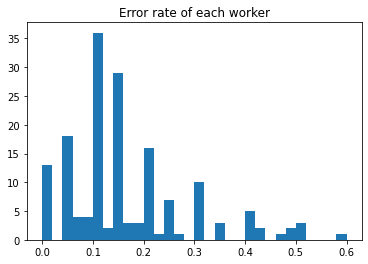

In [17]:
plt.hist(error_worker["error"], bins=30)
plt.title("Error rate of each worker")
plt.savefig("pic/rte_error.png", dpi=300)
plt.show()


In [18]:
error_item = merged.groupby([0]).mean()

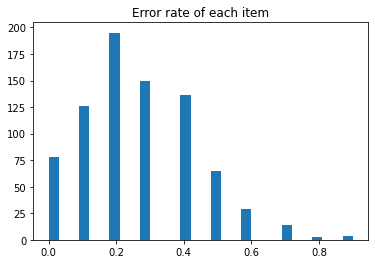

In [19]:
plt.hist(error_item["error"], bins=30)
plt.title("Error rate of each item")
plt.savefig("pic/rte_error_item.png", dpi=300)
plt.show()


In [20]:
confusion_matrix(merged["1_y"], merged[2])


array([[2626, 1374],
       [ 793, 3207]], dtype=int64)

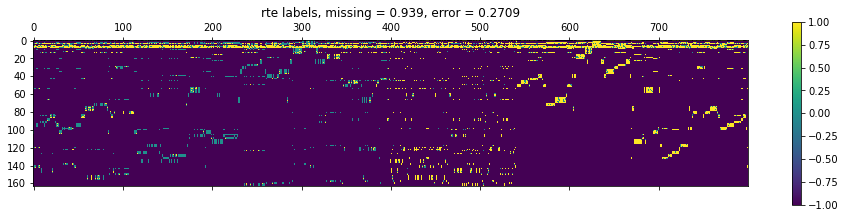

In [21]:
plt.matshow(labels[:, ranking])
plt.title("rte labels, missing = "+str(np.round(missing, 4)) +
          ", error = "+str(np.round(error, 4)))
plt.colorbar()
plt.savefig("pic/rte_labels.png", dpi=300)
plt.show()


In [22]:
def get_confusion_matrix2(k, labels, groups=None, sym=True, cutoff=1e-7, L=50, N=10, seed=None):
    m, n = labels.shape
    if seed is not None:
        np.random.seed(seed)
    if groups is None:
        groups = np.random.randint(3, size=m)
    Zg = get_Zg(k, labels, groups)
    M2s, M3s = get_M(Zg)
    Cc = np.zeros((3, k, k))
    W = np.zeros((3, k))
    for g, (M2, M3) in enumerate(zip(M2s, M3s)):
        Q = get_whiten(M2, sym)
        M3_whiten = whiten_tensor(M3, Q)
        values, vectors = robust_tensor_power(M3_whiten, L, N, sym)
        w = values**-2
        mu = np.linalg.inv(Q.T)@vectors@np.diag(values)
        best = np.argmax(mu, axis=0)

        # prevent multiple mu in same column
        # not_in_best = []
        # not_used_loc = np.array([], dtype=np.int64)
        # for l in range(k):
        #     loc = np.where(best == l)[0]
        #     if len(loc) == 1:
        #         Cc[g, :, l] = mu[:, loc].ravel()
        #         W[g, l] = w[loc]
        #     elif len(loc) == 0:
        #         not_in_best.append(l)
        #     else:
        #         chosen = np.random.randint(len(loc))
        #         Cc[g, :, l] = mu[:, loc[chosen]].ravel()
        #         W[g, l] = w[loc[chosen]]
        #         not_used_loc = np.append(not_used_loc, np.delete(loc, chosen))

        # not_used_loc = np.random.permutation(not_used_loc)
        # for i, l in enumerate(not_in_best):
        #     Cc[g, :, l] = mu[:, not_used_loc[i]].ravel()
        #     W[g, l] = w[not_used_loc[i]]

        # the method in original code
        for h in range(k):
            l = best[h]
            if W[g, l] != 0:
                l = np.where(W[g, :] == 0)[0][0]
            Cc[g, :, l] = mu[:, h].ravel()
            W[g, l] = w[h]

    W = np.mean(W, axis=0)
    C = np.zeros((m, k, k))
    for i in range(m):
        Ca = (np.sum(Cc, axis=0)-Cc[groups[i], :, :])/2
        Za = (np.sum(Zg, axis=0)-Zg[groups[i], :, :])/2
        E = np.zeros((k, k))
        for j in range(n):
            if labels[i, j] != -1:
                E[labels[i, j], :] += Za[j, :]
        E /= n
        Ci = E@np.linalg.inv(W[np.newaxis, :]*Ca.T)
        if cutoff:
            Ci[Ci < cutoff] = cutoff
        colsums = np.sum(Ci, axis=0)
        Ci /= colsums[np.newaxis, :]
        C[i, :, :] = Ci
    return C


In [23]:
C_true = get_true_confusion_matrix(data, truth)


In [24]:
C_true[4,:,:]

array([[0.9, 0.1],
       [0.1, 0.9]])

In [25]:
# baseline
confusion_matrix_loss(np.ones(C_true.shape)/k, C_true)

0.14312329517709166

In [26]:
groups = np.array([i%3 for i in range(m)])

In [27]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, groups=groups, sym=True), C_true)


0.010425562610071989

In [28]:
groups_balance = np.random.permutation(groups)

In [29]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, groups=groups_balance,sym=True), C_true)

0.010226444725547602

In [32]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, sym=True, seed=0), C_true)


0.012222671377328229

In [33]:
confusion_matrix_loss(get_confusion_matrix2(
    k, labels, sym=True, seed=0), C_true)


0.012222671377328229

In [38]:
# iterations
maxiter = 20
step = 1
Ls = np.array([i for i in range(step,maxiter+1,step)],dtype=int)
losses = np.zeros(len(Ls))
for i,L in enumerate(Ls):
    print(L)
    losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=L, N=100, seed=0), C_true)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


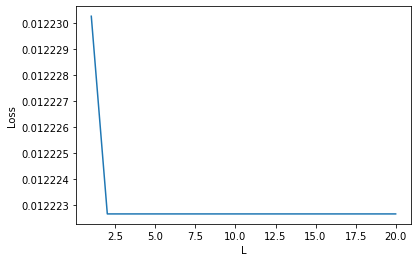

In [39]:
plt.plot(Ls,losses)
plt.xlabel("L")
plt.ylabel("Loss")
plt.savefig("pic/rte_L.png",dpi=300)
plt.show()


In [40]:
# iterations
maxiter = 10
step = 1
Ns = np.array([i for i in range(step, maxiter+1,step)], dtype=int)
losses_N = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    print(N)
    losses_N[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=100, N=N, seed=0), C_true)


1
2
3
4
5
6
7
8
9
10


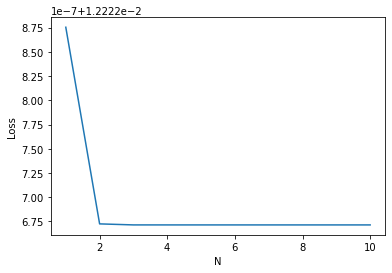

In [41]:
plt.plot(Ns, losses_N)
plt.xlabel("N")
plt.ylabel("Loss")
plt.savefig("pic/rte_N.png", dpi=300)
plt.show()


In [69]:
losses_N

array([0.00974306, 0.00974306, 0.00974306, 0.00974306, 0.00974306,
       0.00974306, 0.00974306, 0.00974306, 0.00974306, 0.00974306])

In [90]:
# symmetric or not
iternum = 500
sym_losses = np.zeros(iternum)
asym_losses = np.zeros(iternum)
for i in range(iternum):
    if i%10==9:
        print(i)
    sym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=20, N=10), C_true)
    asym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=False, L=20, N=10), C_true)

9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199
209
219
229
239
249
259
269
279
289
299
309
319
329
339
349
359
369
379
389
399
409
419
429
439
449
459
469
479
489
499


In [91]:
print(np.min(sym_losses),np.max(sym_losses))
print(np.min(asym_losses), np.max(asym_losses))


0.0066569608477419105 0.36679272744525226
0.006627327623297769 0.26380978133865685


In [92]:
np.percentile(np.append(sym_losses, asym_losses),99)


0.24893358557393622

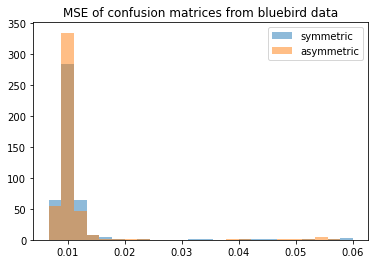

In [94]:
xmin = np.min(np.append(sym_losses,asym_losses))
xmax = np.percentile(np.append(sym_losses, asym_losses), 90)
bins = np.linspace(xmin, xmax, 25)
plt.hist(sym_losses,bins, alpha=0.5, label='symmetric')
plt.hist(asym_losses, bins, alpha=0.5, label='asymmetric')
plt.title("MSE of confusion matrices from rte data")
plt.legend(loc='upper right')
plt.savefig("pic/rte_symmetry.png",dpi=300)
plt.show()


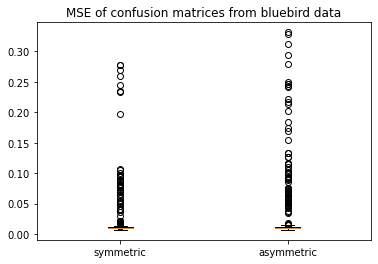

In [89]:
plt.boxplot([sym_losses, asym_losses], labels=['symmetric', 'asymmetric'])
plt.title("MSE of confusion matrices from rte data")
plt.savefig("pic/rte_symmetry_box.png", dpi=300)
plt.show()


From the plot we can see if we symmetricalize the matrices and tensors, the MSE of the confusion matrices can be reduced.

In [75]:
# symmetric or not
iternum = 100
new_losses = np.zeros(iternum)
original_losses = np.zeros(iternum)
for i in range(iternum):
    if i % 10 == 9:
        print(i)
    new_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=10, N=10), C_true)
    original_losses[i] = confusion_matrix_loss(get_confusion_matrix2(
        k, labels, sym=True, L=10, N=10), C_true)


9
19
29
39
49
59
69
79
89
99


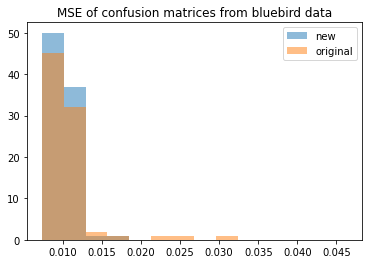

In [76]:
xmin = np.min(np.append(sym_losses, asym_losses))
xmax = np.percentile(np.append(sym_losses, asym_losses), 95)
bins = np.linspace(xmin, xmax, 15)
plt.hist(new_losses, bins, alpha=0.5, label='new')
plt.hist(original_losses, bins, alpha=0.5, label='original')
plt.title("MSE of confusion matrices from rte data")
plt.legend(loc='upper right')
plt.savefig("pic/rte_singular.png",dpi=300)
plt.show()


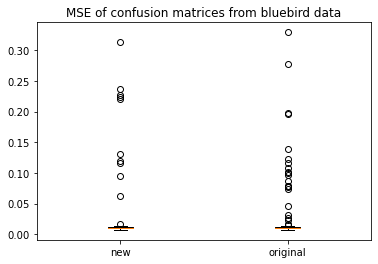

In [77]:
plt.boxplot([new_losses, original_losses], labels=['new', 'original'])
plt.title("MSE of confusion matrices from rte data")
plt.savefig("pic/rte_singular_box.png", dpi=300)
plt.show()


In [78]:
# balance or not
iternum = 100
balance_losses = np.zeros(iternum)
inbalance_losses = np.zeros(iternum)
for i in range(iternum):
    if i % 10 == 9:
        print(i)
    balance_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, groups=np.random.permutation([i % 3 for i in range(m)]), L=10, N=10), C_true)
    inbalance_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True, L=10, N=10), C_true)


9
19
29
39
49
59
69
79
89
99


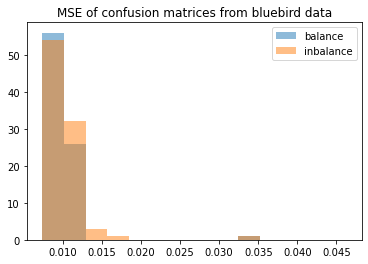

In [79]:
xmin = np.min(np.append(sym_losses, asym_losses))
xmax = np.percentile(np.append(sym_losses, asym_losses), 95)
bins = np.linspace(xmin, xmax, 15)
plt.hist(balance_losses, bins, alpha=0.5, label='balance')
plt.hist(inbalance_losses, bins, alpha=0.5, label='inbalance')
plt.title("MSE of confusion matrices from rte data")
plt.legend(loc='upper right')
# plt.savefig("pic/rte_singular.png",dpi=300)
plt.show()


In [80]:
np.max(balance_losses)

0.24380891340979552

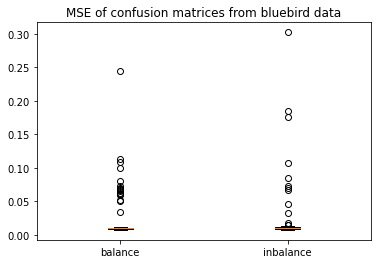

In [81]:
plt.boxplot([balance_losses, inbalance_losses],
            labels=['balance', 'inbalance'])
plt.title("MSE of confusion matrices from rte data")
plt.savefig("pic/rte_balance_box.png", dpi=300)
plt.show()
